In [1]:
using Agents, Distributions, StatsBase, DataFrames, Plots, Test

In [2]:
"""
    random_agent_model(model, agent_types)
Return the id of a random agent from the model of a certain type/s or -1 if there are no agents of this type
"""
function random_agent_type(model, agent_types)
    subdict = Dict(id => agent for (id, agent) in model.agents if typeof(agent) in agent_types)
    try 
        model[rand(keys(subdict))].id
    catch
        -1
    end
end

"""
    increment_dict!(dict, key, by=1)
Modify a dictionary element by a specified amount or set it to this amount if the key isn't present in the dictionary.
"""
function increment_dict!(dict, key, by=1)
     if haskey(dict, key)
        dict[key] += by
    else
        dict[key] = by
    end
end

increment_dict!

In [3]:
mutable struct Sitter <: AbstractAgent
    id::Int
    eggs_laid::Int # How many eggs the agent lays
    egg_ids::Dict # Dictionary of the `id`s that have put an egg in this nest and their counts
    utility::Float64
end

mutable struct Identifier <: AbstractAgent
    id::Int
    eggs_laid::Int # How many eggs the agent lays
    egg_ids::Dict # Dictionary of the `id`s that have put an egg in this nest and their counts
    p_identify::Float64 # Probability of correctly identifying own agents
    utility::Float64
end

mutable struct Cheater <: AbstractAgent
    id::Int
    eggs_laid::Int # How many eggs the agent lays
    egg_ids::Dict
    utility::Float64
end

In [4]:
# Move order: Cheaters, Identifiers, Sitters, Model
# Could be in for loop to lay more than 1 egg

function agent_step!(cheater::Cheater, model)
    if random_agent_type(model, [Sitter, Identifier]) != -1 # Will return -1 if there are no nests
        for _ in 1:cheater.eggs_laid
            rand_agent_id = random_agent_type(model, [Sitter, Identifier]) # Choose a random nest (i.e. random sitter or identifier)
            increment_dict!(model[rand_agent_id].egg_ids, cheater.id)
        end
    end
end

function agent_step!(identifier::Identifier, model)
    p = identifier.p_identify
    id = identifier.id
    eggs_laid = identifier.eggs_laid
    
    # Replace the dictionary with only your own eggs if perfect identification, else randomly destroy eggs from other birds
    if p == 1.0
        identifier.egg_ids = Dict(id => eggs_laid)
    else
        identifier.egg_ids[id] = rand(Binomial(eggs_laid, p))
        for other_id in setdiff(keys(identifier.egg_ids), [id])
            identifier.egg_ids[other_id] =  rand(Binomial(identifier.egg_ids[other_id], 1 - p))
        end
    end
end

function agent_step!(sitter::Sitter, model)
    sitter.egg_ids[sitter.id] = sitter.eggs_laid
end

agent_step! (generic function with 3 methods)

In [5]:
function reproduce!(agent_type, model)
    id = nextid(model)
    if agent_type == Cheater
        offspring = Cheater(id, model.eggs_laid, Dict{Int, Int}(), 0)
        model.cheaters_extinct = 0
    elseif agent_type == Identifier
        offspring = Identifier(id, model.eggs_laid, Dict{Int, Int}(), model.p_identify, 0)
        model.identifiers_extinct = 0
    else
        offspring = Sitter(id, model.eggs_laid, Dict{Int, Int}(), 0)
        model.sitters_extinct = 0
    end
    add_agent!(offspring, model)
end


reproduce! (generic function with 1 method)

In [6]:
function model_step!(model)
    nonextinct_types = unique(typeof.(allagents(model)))

    # Aggregate all egg_ids of non-extinct types into an array of IDs 
    nest_id_array = [id for (id, agent) in model.agents if typeof(agent) in intersect([Sitter, Identifier], nonextinct_types)]
    hatched_egg_dict = Dict{Int64,Int64}()
    for nest_id in nest_id_array
        for (egg_id, tally) in model.agents[nest_id].egg_ids
            increment_dict!(hatched_egg_dict, egg_id, tally)
        end
    end

    # Calculate utility of each agent and then type
    for (key, agent) in model.agents
        agent.utility = model.hatch_utility * get(hatched_egg_dict, key, 0) +
            Int(!isa(agent, Cheater)) * -model.egg_cost * get(agent.egg_ids, key, 0) +
            Int(isa(agent, Identifier)) * -model.identify_cost
    end

    utilities = [
        sum(
            agent.utility
            for
            (key, agent) in
            Dict(id => agent for (id, agent) in model.agents if agent isa agent_type)
        ) for agent_type in nonextinct_types
    ]
    
    # Resample population weighted by utility
    total_agents = nagents(model)
    genocide!(model) # Kill all current agents before next batch are created in order to keep total_agents the same
    n_offspring = countmap(sample(nonextinct_types, Weights(utilities), total_agents))
    for (agent_type, count) in n_offspring
        for _ in 1:n_offspring[agent_type]
            reproduce!(agent_type, model)
        end
    end
    
    # Mutate population
    if rand() < model.p_mutation
        kill_agent!(random_agent(model), model) # Kill a random member in order to keep number of agents the same
        reproduce!(rand([Sitter, Identifier, Cheater]), model) # Sample from all 3 types as NSS can be interior
    end
    
    for variable in [model.sitters_extinct, model.identifiers_extinct, model.cheaters_extinct]
        variable = 1
    end
end

model_step! (generic function with 1 method)

In [7]:
function evolutionary_model(;
        num_sitters = 1,
        num_identifiers = 1,
        num_cheaters = 1,
        hatch_utility = 5.0,
        egg_cost = 2.0,
        eggs_laid = 1,
        identify_cost = 1.0,
        p_identify = 1,
        p_mutation=0
    )
    
    # Create model
    model = ABM(
        Union{Cheater, Identifier, Sitter},
        scheduler = by_type(false, true),
        properties = Dict(
            :eggs_laid => eggs_laid,
            :hatch_utility => hatch_utility,
            :egg_cost => egg_cost,
            :identify_cost => identify_cost,
            :p_identify => p_identify, 
            :p_mutation => p_mutation,
            :sitters_extinct => 1,
            :identifiers_extinct => 1,
            :cheaters_extinct => 1,
        ),
        warn = false # For use with mixed-agent models, supresses type warning
    )
    
    # Add agents to model
    id = 0
    for _ in 1:num_sitters
        id += 1
        sitter = Sitter(id, eggs_laid, Dict{Int, Int}(), 0)
        add_agent!(sitter, model)
    end
    
    for _ in 1:num_identifiers
        id += 1
        identifier = Identifier(id, eggs_laid, Dict{Int, Int}(), p_identify, 0)
        add_agent!(identifier, model)
    end
    
    for _ in 1:num_cheaters
        id += 1
        cheater = Cheater(id, eggs_laid, Dict{Int, Int}(), 0)
        add_agent!(cheater, model)
    end
    return model
end

evolutionary_model (generic function with 1 method)

## Tests

In [13]:
@testset "extinctions" begin
    # Can it handle a single type going extinct?
    @test begin 
        model1 = evolutionary_model(;
            num_sitters = 0,
            num_identifiers = 1,
            num_cheaters = 1,
            hatch_utility = 5.0,
            egg_cost = 1,
            identify_cost = 1,
            eggs_laid = 1,
            p_identify = 1,
        )
        model_step!(model) isa Any
    end
    # Can it handle multiple types going extinct?
    @test begin model2 = evolutionary_model(;
                    num_sitters = 0,
                    num_identifiers = 0,
                    num_cheaters = 1,
                    hatch_utility = 5.0,
                    egg_cost = 1,
                    identify_cost = 1,
                    eggs_laid = 1,
                    p_identify = 1,)
        run!(model2, agent_step!, model_step!, 10) isa Any
    end
end;

Test Summary: | Pass  Total
extinctions   |    2      2


## Running Models

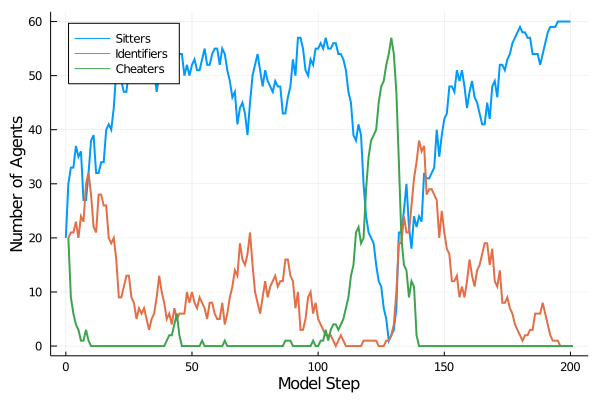

In [16]:
model = evolutionary_model(;
    num_sitters = 20,
    num_identifiers = 20,
    num_cheaters = 20,
    hatch_utility = 5.2,
    egg_cost = 1.05,
    identify_cost = 0.22,
    eggs_laid = 1,
    p_identify = 1,
    p_mutation = 0.3
)

sitters(a) = typeof(a) == Sitter
identifiers(a) = typeof(a) == Identifier
cheaters(a) = typeof(a) == Cheater
adata = [(sitters, count), (identifiers, count), (cheaters, count)]
results, _ = run!(model, agent_step!, model_step!, 200; adata = adata);

plot = Plots.plot(results.step, results.count_sitters, label = "Sitters", lw = 2, legend=:topleft)
plot!(plot, results.count_identifiers, label = "Identifiers",lw = 2)
plot!(plot, results.count_cheaters, label = "Cheaters", lw = 2)
xlabel!(plot, "Model Step")
ylabel!(plot, "Number of Agents")

## TODO:

* Investigate how a population of Cheaters can sustain themselves.
* See what a non-resampling method would look like to avoid the huge jumps in population that come from an Identifier mutating in a Cheater population.

## Code for a different type of reproduction

In [10]:
# function reproduce2!(agent_type::Union{Cheater, Identifier, Sitter}, model)
#     id = nextid(model)
# #     if rand() < model.p_mutation
# #         agent_type = rand(setdiff([Sitter, Identifier, Cheater], [agent_type]))
# #     end
#     if agent_type == Cheater
#         offspring = Cheater(id, model.eggs_laid, Dict{Int, Int}(), 0)
#         model.cheaters_extinct = 0
#     elseif agent_type == Identifier
#         offspring = Identifier(id, model.eggs_laid, Dict{Int, Int}(), model.p_identify, 0)
#         model.identifiers_extinct = 0
#     else
#         offspring = Sitter(id, model.eggs_laid, Dict{Int, Int}(), 0)
#         model.sitters_extinct = 0
#     end
#     add_agent!(offspring, model)
# end


In [11]:
# function model_step2!(model)
#     nonextinct_types = unique(typeof.(allagents(model)))

#     # Aggregate all egg_ids of non-extinct types into an array of IDs 
#     nest_id_array = [id for (id, agent) in model.agents if typeof(agent) in intersect([Sitter, Identifier], nonextinct_types)]
#     hatched_egg_dict = Dict{Int64,Int64}()
#     for nest_id in nest_id_array
#         for (egg_id, tally) in model.agents[nest_id].egg_ids
#             increment_dict!(hatched_egg_dict, egg_id, tally)
#         end
#     end
    
#     total_agents = nagents(model)
#     total_offspring = 0
#     # Calculate utility of each agent and reproduce based on this, then kill the agent
#     for (key, agent) in model.agents
#         agent.utility = model.hatch_utility * get(hatched_egg_dict, key, 0) +
#             Int(!isa(agent, Cheater)) * -model.egg_cost * get(agent.egg_ids, key, 0) +
#             Int(isa(agent, Identifier)) * -model.identify_cost
        
#         n_offspring = (3 * agent.utility) ÷ (model.hatch_utility + model.egg_cost + model.identify_cost)
#         if n_offspring > 0
#             total_offspring += n_offspring
#             for _ in 1:n_offspring
#                 reproduce2!(typeof(agent), model)
#             end
#         end
#         kill_agent!(agent, model)
#     end
    
#     # println("expect: ", total_offspring) # These should be equal
#     # println("have: ", nagents(model))
    
    
#     # Reset extinct variables
#     for variable in [model.sitters_extinct, model.identifiers_extinct, model.cheaters_extinct]
#         variable = 1
#     end
# end

In [12]:
# model2 = evolutionary_model(;
#     num_sitters = 20,
#     num_identifiers = 20,
#     num_cheaters = 20,
#     hatch_utility = 5.2,
#     egg_cost = 1.05,
#     identify_cost = 0.22,
#     eggs_laid = 1,
#     p_identify = 1,
#     p_mutation = 0.1,
# )

# sitters(a) = typeof(a) == Sitter
# identifiers(a) = typeof(a) == Identifier
# cheaters(a) = typeof(a) == Cheater
# adata = [(sitters, count), (identifiers, count), (cheaters, count)]
# results, _ = run!(model2, agent_step!, model_step2!, 20; adata = adata);

# plot = Plots.plot(results.step, results.count_sitters, label = "Sitters", lw = 2, legend=:topleft)
# plot!(plot, results.count_identifiers, label = "Identifiers",lw = 2)
# plot!(plot, results.count_cheaters, label = "Cheaters", lw = 2)
# xlabel!(plot, "Model Step")
# ylabel!(plot, "Number of Agents")